In [75]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import airportsdata

%matplotlib inline

In [76]:
data = pd.read_csv(f'data{os.sep}flight_delays_train.csv')
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [77]:
df = data.copy()

# Preprocessing

In [78]:
df['Month'] = data['Month'].apply(lambda x: int(x.split('-')[1]))
df['DayofMonth'] = data['DayofMonth'].apply(lambda x: int(x.split('-')[1]))
df['DayOfWeek'] = data['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
df['DepTime'] = data['DepTime'].apply(lambda x: x % 2400)

In [79]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


In [80]:
df['DepTime'] = pd.cut(x=df['DepTime'], bins=[0, 600, 1200, 1800, 2399], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

In [81]:
df['DepTime']

0          Evening
1        Afternoon
2        Afternoon
3          Morning
4          Evening
           ...    
99995    Afternoon
99996      Morning
99997      Evening
99998    Afternoon
99999    Afternoon
Name: DepTime, Length: 100000, dtype: category
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

### Quantile Discretization ?

In [82]:
#df['DepTime'] = pd.qcut(x=df['DepTime'], q=4, labels=['Night', 'Morning', 'Afternoon', 'Evening'])

In [83]:
#df['DepTime']

/tmp/ipykernel_5132/1187805376.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['DepTime', 'dep_delayed_15min']].groupby(


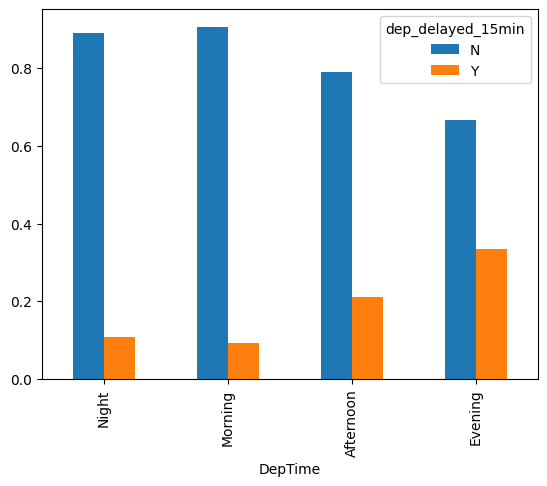

In [84]:
df[['DepTime', 'dep_delayed_15min']].groupby(
    'DepTime').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)
plt.show()

### Distance

In [85]:
df['Distance'] = pd.qcut(x=data['Distance'], q=5, labels=['Very short', 'Short', 'Medium', 'Long', 'Very long'])

/tmp/ipykernel_5132/1922755979.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['Distance', 'dep_delayed_15min']].groupby(


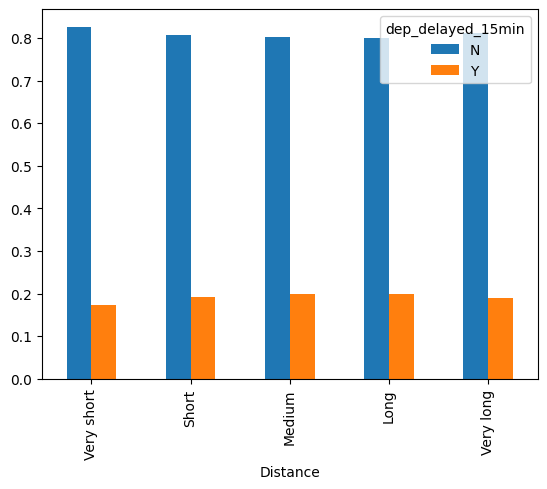

In [86]:
df[['Distance', 'dep_delayed_15min']].groupby(
    'Distance').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)
plt.show()

### Airports

In [87]:
airports = airportsdata.load('IATA')

In [88]:
def get_airport_location(airport_code):
    try:
        iata_code = airports[airport_code]['subd']
    except KeyError:
        if airport_code == 'PFN':
            iata_code = 'Florida'
        else:
            iata_code = 'Unknown'
    return iata_code

In [89]:
df['Origin'] = data['Origin'].apply(lambda x: get_airport_location(x))
df['Dest'] = data['Dest'].apply(lambda x: get_airport_location(x))

In [90]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,Evening,AA,Georgia,Texas,Long,N
1,4,20,3,Afternoon,US,Pennsylvania,Florida,Long,N
2,9,2,5,Afternoon,XE,North Carolina,Ohio,Short,N
3,11,25,6,Morning,OO,Colorado,Tennessee,Long,N
4,10,7,6,Evening,WN,Illinois,Nebraska,Short,Y


<Axes: xlabel='DayOfWeek'>

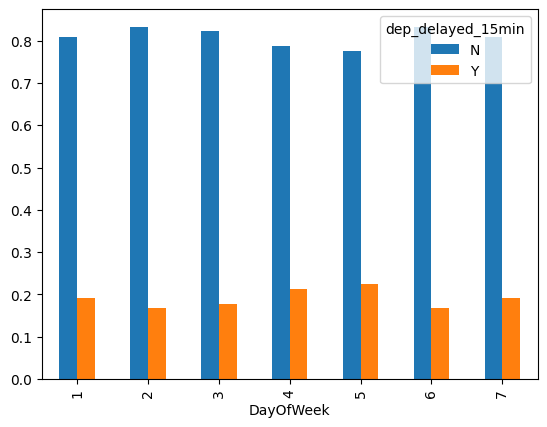

In [91]:
df[['DayOfWeek', 'dep_delayed_15min']].groupby(
    'DayOfWeek').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)

In [92]:
df['DayOfWeek'].describe()

count    100000.00000
mean          3.95183
std           1.99164
min           1.00000
25%           2.00000
50%           4.00000
75%           6.00000
max           7.00000
Name: DayOfWeek, dtype: float64

I want to plot the unique carrier number of flights (also with the delay and not deelay) by weighting them inversally w.r.t. the number of flights

<Axes: xlabel='UniqueCarrier'>

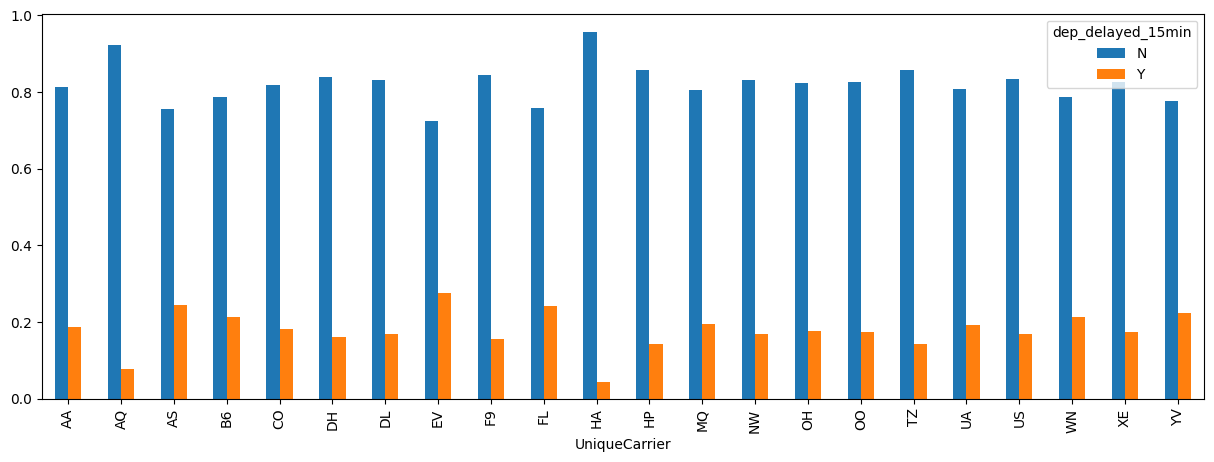

In [93]:
df[['UniqueCarrier', 'dep_delayed_15min']].groupby(
    'UniqueCarrier').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False, figsize=(15, 5))

In [94]:
df['Weekend'] = data['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)

In [95]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Weekend
0,8,21,7,Evening,AA,Georgia,Texas,Long,N,0
1,4,20,3,Afternoon,US,Pennsylvania,Florida,Long,N,0
2,9,2,5,Afternoon,XE,North Carolina,Ohio,Short,N,0
3,11,25,6,Morning,OO,Colorado,Tennessee,Long,N,0
4,10,7,6,Evening,WN,Illinois,Nebraska,Short,Y,0


In [96]:
def season(month, day):
    # return the season based on month and day

    complete_num = f"{month}{day}"
    complete_num = int(complete_num)

    if 320 <= complete_num <= 620:
        return 'Spring'
    elif 621 <= complete_num <= 922:
        return 'Summer'
    elif 923 <= complete_num <= 1221:
        return 'Fall'
    else:
        return 'Winter'

In [97]:
df['Season'] = df.apply(lambda x: season(x['Month'], x['DayofMonth']), axis=1)

<Axes: xlabel='Season'>

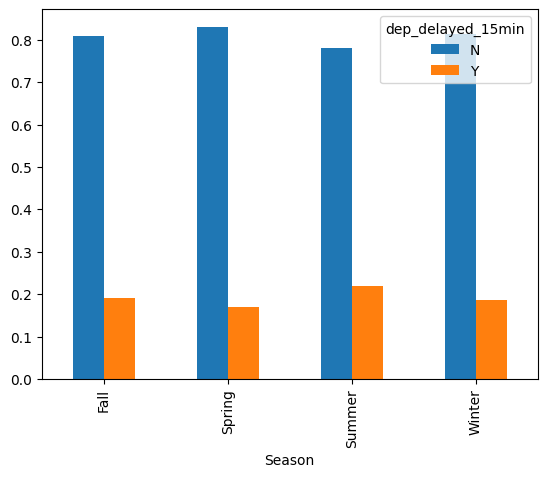

In [98]:
df[['Season', 'dep_delayed_15min']].groupby(
    'Season').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)

In [99]:
df['dep_delayed_15min'] = df['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
df.rename(columns={'dep_delayed_15min': 'Delayed'}, inplace=True)

In [100]:
df = df.reindex(columns=['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'Origin', 'Dest', 'UniqueCarrier', 'Weekend', 'Season', 'Delayed'])

In [101]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,Origin,Dest,UniqueCarrier,Weekend,Season,Delayed
0,8,21,7,Evening,Long,Georgia,Texas,AA,0,Summer,0
1,4,20,3,Afternoon,Long,Pennsylvania,Florida,US,0,Spring,0
2,9,2,5,Afternoon,Short,North Carolina,Ohio,XE,0,Winter,0
3,11,25,6,Morning,Long,Colorado,Tennessee,OO,0,Fall,0
4,10,7,6,Evening,Short,Illinois,Nebraska,WN,0,Winter,1


In [102]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

from collections import defaultdict

import networkx as nx

# Naive Bayes

In [103]:
nb_model = BayesianNetwork([('Delayed', 'Month'), ('Delayed', 'DayofMonth'), ('Delayed', 'DayOfWeek'), ('Delayed', 'DepTime'), ('Delayed', 'Distance'), ('Delayed', 'Origin'), ('Delayed', 'Dest'), ('Delayed', 'UniqueCarrier'), ('Delayed', 'Weekend'), ('Delayed', 'Season')])

In [104]:
nb_model.nodes()

NodeView(('Delayed', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'Origin', 'Dest', 'UniqueCarrier', 'Weekend', 'Season'))

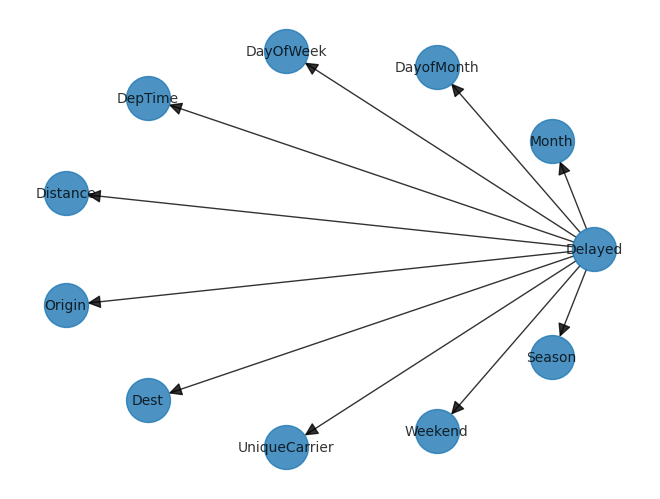

CPU times: user 351 ms, sys: 304 ms, total: 655 ms
Wall time: 284 ms


In [105]:
%%time
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [106]:
nb_model.fit(df)
nb_cpds = nb_model.get_cpds()
if not nb_model.check_model():
    print('The NB model has errors.')
else:
    print('The NB model has no errors.')

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


The NB model has no errors.


In [107]:
def predict(data, inf, target_variable):
    '''
    Given a Dataframe, an inference object and a target variable,
    perform prediction and return the obtained results
    '''
    results = defaultdict(list)
    for _, data_point in data.iterrows():
        if 'index' in data_point:
            del data_point['index']
        result = inf.query(
            variables=[target_variable],
            evidence=data_point.to_dict(),
            show_progress=True,
        )
        values = result.state_names[target_variable]
        for i, val in enumerate(values):
            results[val].append(result.values[i])
    return results

In [108]:
nb_inference = VariableElimination(nb_model)
nb_results = predict(df.drop('Delayed', axis=1).reset_index(), nb_inference, 'Delayed')
nb_mean_results = {}
for k, v in nb_results.items():
    nb_mean_results[k] = np.nanmean(v)
print(nb_mean_results)

KeyError: nan